# Disentangle Deep Features in Generative Convolution Network for Interpretable Neural-based Synthesis Applications

---
## 1. Introduction
---

The [original caffe pretrained weights of VGG19](https://github.com/jcjohnson/pytorch-vgg) were used for this implementation, instead of the pretrained VGG19's in PyTorch's model zoo.

**PRETRAINED VGG MODELS *(Link to download)*:**

[VGGNet-19](https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth (Download))

---
## 2. Setup and Configuration
---

### 2.1 Import Libraries

In [2]:
# Load the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
from torchsummary import summary

import os
import csv
from datetime import datetime
import pandas as pd

### 2.2 Define Hyperparameters, Constants, and Paths

**Optimizer**

* `OPTIMIZER`: Set the optimizer to either `'adam'` or `'lbfgs'`. Default optimizer is `Adam` with learning rate of `10`. L-BFGS optimizer was used in the original (matlab) implementation of the reference paper.

* `ADAM_LR`: Learning rate of the Adam optimizer. Default is `1e1`.
* `CONTENT_WEIGHT`: Multiplier weight of the loss between content representations and the generated image. Default is `5e0`.
* `STYLE_WEIGHT`: Multiplier weight of the loss between style representations and the generated image. Default is `1e2`.
* `TV_WEIGHT`: Multiplier weight of the [Total Variation Denoising](https://github.com/jcjohnson/neural-style/issues/302). Default is `1e-3`.
* `NUM_ITER`: Iterations of the style transfer. Default is `100`.
* `SHOW_ITER`: Number of iterations before showing and saving the generated image. Default is `20`.

**Image**

* `MAX_IMAGE_SIZE`: Set the max dimension of height or weight. Bigger GPU memory is needed to run larger images. Default is `512`px.

* `INIT_IMAGE`: Set the initial image file to either `'random'` or `'content'`. Default is `random` which initializes a noise image. Content copies a resized content image, giving free optimization of content loss!
* `PRESERVE_COLOR`: Determine whether to preserve the colour of the content image. `True` preserves the colour of the content image. Default value is `False`.
* `PIXEL_CLIP`: Determine whether to clip the resulting image. `True` clips the pixel values to [0, 255]. Default value is `True`.
* `CONTENT_PATH`: Path of the content image.
* `STYLE_PATH`: Path of the style image.

**Model**

* `VGG19_PATH`: Path of VGG19 Pretrained weights. Default is `'models/vgg19-d01eb7cb.pth'`.

* `POOL`: Define which pooling layer to use. The reference paper suggests using average pooling! Default is `'max'`.

In [3]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'adam' # or 'lbfgs'
ADAM_LR = 10 
CONTENT_WEIGHT = 5e0 
STYLE_WEIGHT = 5e0 
TV_WEIGHT = 1e-3 
NUM_ITER = 100 
SHOW_ITER = 20 

# Image Files
INIT_IMAGE = 'random' # or 'content'
PRESERVE_COLOR = False # or True
PIXEL_CLIP = True # or False - Clipping produces better images
CONTENT_PATH = 'images/Content_4.jpg' 
STYLE_PATH = 'images/Style_1.jpg' 

VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
POOL = 'max' # or 'avg'

### 2.3 Check Device
*Purpose: Configure the device for computation.*

In [4]:
# Print the device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


---
## 3. Utility Functions
---

### 3.1 Load Image Function
*Purpose: Load an image from a specified file path.*

Line 3: Use OpenCV's `cv2.imread` function to read the image from the given `path`. The image is loaded in BGR (Blue, Green, Red) format, which is the default colour format for OpenCV.

In [5]:
# Function to load image 
def load_image(path):
    img = cv2.imread(path) # Images loaded as BGR
    return img

### 3.2 Display Image Function
*Purpose: Display an image using Matplotlib.*

Line 4: Convert the image from BGR format to RGB format using `cv2.cvtColor`, as Matplotlib uses RGB format. 

Line 7: Normalize the image pixel values to the range [0, 1]. Divide the image by 255 to convert the pixel values from the range [0, 255] to [0, 1]. Use `np.array(img / 255)` to create a new array with normalized values. Apply `clip(0, 1)` to ensure that all values are within the range [0, 1]. This is necessary because `plt.imshow` in Matplotlib can only handle images with pixel values in this range when using floats.

Line 9: Create a new figure with a specified size of 10 $ \times $ 5 inches.

Line 10: Add the image data (`img`) to the current figure, preparing it for display. It sets up the visualization by interpreting the array data as an image, but it does not actually render it to the screen. This function is responsible for handling the image data and preparing it for display, but the image won't be visible until the plot is rendered.

Line 11: Render the figure, showing the image inline in a Jupyter Notebook.

In [6]:
# Function to display image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # imshow() only accepts float [0, 1] or int [0, 255]
    img = np.array(img / 255).clip(0, 1)

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

### 3.3 Save Image Function
*Purpose: Save an image to a file with a specific naming convention.*

In [7]:
def save_image(img, iters, directory='outputs', prefix='out', content_num=None, style_num=None):
    # Extract content and style numbers from the paths if not provided
    if content_num is None and CONTENT_PATH:
        # Extract number from Content_X.jpg format
        content_num = CONTENT_PATH.split('Content_')[-1].split('.')[0]
    if style_num is None and STYLE_PATH:
        # Extract number from Style_X.jpg format
        style_num = STYLE_PATH.split('Style_')[-1].split('.')[0]
    
    # Create base directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Create subfolder based on content and style numbers if both are available
    if content_num is not None and style_num is not None:
        subfolder = f'Content{content_num}_Style{style_num}'
        
        # Special handling for frequency images
        if directory == 'outputs/L-H_Frequency_Images':
            # Don't create 'outputs' subfolder for frequency images
            directory = os.path.join(directory, subfolder)
        else:
            directory = os.path.join(directory, subfolder)
        
        os.makedirs(directory, exist_ok=True)
    
    # Clip pixel values if enabled
    if PIXEL_CLIP:
        img = img.clip(0, 255)
    
    # Construct filename
    if directory.startswith('outputs/L-H_Frequency_Images'):
        # For frequency images
        if isinstance(iters, str):
            if 'content' in iters:
                filename = f"{iters}_c{content_num}.png"
            elif 'style' in iters:
                filename = f"{iters}_s{style_num}.png"
    else:
        # For style transfer outputs
        filename = f"{prefix}_C{content_num}_S{style_num}_{iters}.png"
    
    # Combine directory and filename
    filepath = os.path.join(directory, filename)
    
    # Save the image
    cv2.imwrite(filepath, img)
    
    return filepath  # Return the full path for reference

### 3.4 Loss Logging Function

In [8]:
def log_losses(iteration, losses, nst_type, content_num=None, style_num=None):
    # Extract numbers from global paths if not provided
    if content_num is None and CONTENT_PATH:
        content_num = CONTENT_PATH.split('Content_')[-1].split('.')[0]
    if style_num is None and STYLE_PATH:
        style_num = STYLE_PATH.split('Style_')[-1].split('.')[0]
        
    # Define the excel filename and path
    excel_filename = f'{nst_type}_losses.xlsx'
    excel_path = os.path.join('outputs', nst_type, excel_filename)
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.join('outputs', nst_type), exist_ok=True)
    
    sheet_name = f'Content{content_num}_Style{style_num}'
    
    try:
        # Try to load existing workbook
        if os.path.exists(excel_path):
            wb = pd.read_excel(excel_path, sheet_name=None, engine='openpyxl')
            # Check if sheet exists
            if sheet_name in wb:
                df = wb[sheet_name]
                new_row = pd.DataFrame({
                    'Iteration': [iteration],
                    'Style Loss': [losses.get('style', None)],
                    'Content Loss': [losses.get('content', None)],
                    'TV Loss': [losses.get('tv', None)],
                    'Total Loss': [losses.get('total', None)]
                })
                df = pd.concat([df, new_row], ignore_index=True)
            else:
                df = pd.DataFrame({
                    'Iteration': [iteration],
                    'Style Loss': [losses.get('style', None)],
                    'Content Loss': [losses.get('content', None)],
                    'TV Loss': [losses.get('tv', None)],
                    'Total Loss': [losses.get('total', None)]
                })
            
            # Update the workbook with all sheets
            wb[sheet_name] = df
            
            # Save all sheets back to the Excel file
            with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
                for sheet in wb:
                    wb[sheet].to_excel(writer, sheet_name=sheet, index=False)
                    
        else:
            # Create new workbook with first sheet
            df = pd.DataFrame({
                'Iteration': [iteration],
                'Style Loss': [losses.get('style', None)],
                'Content Loss': [losses.get('content', None)],
                'TV Loss': [losses.get('tv', None)],
                'Total Loss': [losses.get('total', None)]
            })
            df.to_excel(excel_path, sheet_name=sheet_name, index=False)
            
    except Exception as e:
        print(f"Error logging losses: {str(e)}")

### 3.5 Colour Transfer Function
*Purpose: Transfer the colour characteristics from one image (source) to another image (destination) while preserving the destination's luminance (brightness) information.*

Line 3-4: If `PIXEL_CLIP` is `True`, clip the pixel values of both source (`src`) and destination (`dest`) images to the range [0, 255]. 

Line 8: Resize the destination image to match the dimensions of the source image using cubic interpolation, ensuring both images have the same size for pixel-wise operations.

Line 10: Convert the destination image to grayscale using `cv2.cvtColor` to extract its luminance component. 

Line 11: Convert the source image from BGR to YCrCb colour space using `cv2.cvtColor` to separate its luminance (Y) and chrominance (Cr & Cb) components. 

Line 12: The luminance component of the source image is replaced with the grayscale luminance from the destination image. This step transfers the colour characteristics of the source image while maintaining the luminance of the destination image.

Line 13: Convert the modified source image back to BGR colour space.

In [9]:
# Function to transfer colour
def transfer_color(src, dest):
    if PIXEL_CLIP:
        src, dest = src.clip(0, 255), dest.clip(0, 255)
        
    # Resize src to dest's size
    H, W, _ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY)  # Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)    # Convert the Source from BGR to YCrCb
    src_yiq[..., 0] = dest_gray                         # Combine Destination's luminance and Source's Cr & Cb
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)   # Convert new image from YIQ back to BGR

### 3.6 Image Preprocessing

#### 3.6.1 Image to Tensor Function
*Purpose: Convert an image from its original format to a PyTorch tensor suitable for model input, including resizing and normalization.*

Line 8: Extract the height, width, and channels of the image. 

Line 9: `max([H, W])` identifies the larger dimension between height and width. `float(MAX_IMAGE_SIZE) / max([H, W])` computes the scaling factor needed to ensure the largest dimension equals `MAX_IMAGE_SIZE`. The scaling factor is then multiplied by each of the original dimensions (`H` and `W`) to maintain the aspect ratio. `int()` is used to convert the scaled dimensions into integer values, as pixel dimensions must be whole numbers. `tuple()` converts the list of new dimensions into a tuple.

Line 11: Use `transforms.Compose` to create a sequence of transformations. 

Line 12: `transforms.ToPILImage()` converts the image (NumPy array) to PIL format. 

Line 13: `transforms.Resize(image_size)` resizes the image to the calculated size (`image_size`). 

Line 14: `transforms.ToTensor()` converts the resized image to a PyTorch tensor with values scaled in the range [0, 1].

Line 18: A normalization transformation `normalize_t` is created. `transforms.Normalize` is a PyTorch transformation used to normalize images by subtracting mean values and dividing by standard deviation values for each channel. In this case, the means for the three channels (Red, Green, and Blue) are `[103.939, 116.779, 123.68]` (mentioned in [GitHub](https://github.com/jcjohnson/pytorch-vgg (@jcjohnson))). The standard deviations for all three channels are set to `[1, 1, 1]`, meaning no scaling is applied beyond the mean subtraction.

Line 19: `itot_t(img)` applies the composed transformations (convert to PIL image, resize, and convert to tensor) to the input image `img`. After converting to a tensor, multiply the tensor by 255 to change the range of pixel values from [0, 1] to [0, 255] (as previously `ToTensor()` normalized it to [0, 1]), which is the standard range for image pixel values. The `normalize_t` transform is applied to the tensor resulting from `itot_t(img) * 255`. This transform subtracts the mean values `[103.939, 116.779, 123.68]` from each channel of the image tensor.

Line 22: Add an extra dimension at the beginning to represent the batch size, setting it to 1.

Line 23: Return a normalized PyTorch tensor with an added batch dimension.

In [10]:
# Image to tensor function
def image_to_tensor(img):
    # If the image is grayscale, convert to 3-channel
    if len(img.shape) == 2:  # Grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H, W])) * x) for x in [H, W]])

    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68], [1, 1, 1])
    tensor = normalize_t(itot_t(img) * 255)

    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

#### 3.6.2 Tensor to Image Function
*Purpose: Convert a normalized PyTorch tensor back to a NumPy image format.*

Line 4-6: Define a denormalization transform `transforms.Normalize` with mean values `[-103.939, -116.779, -123.68]` and standard deviations `[1, 1, 1]`. This is the inverse of the normalization applied in `image_to_tensor`. Adding these negative means is equivalent to subtracting the positive means used earlier.

Line 9: Use `tensor.squeeze()` to remove the batch size dimension, assuming the input tensor has a batch size of 1. 

Line 10: Apply the denormalization transform to the tensor to add back the mean values.

Line 11: Move the tensor to CPU memory using `tensor.cpu()`. Convert the tensor to a NumPy array.

Line 14: Transpose the array from `[C, H, W]` (channels first, PyTorch format) to `[H, W, C]` (common image format).

Line 15: Return a NumPy array representing the image with original colour values restored.

In [11]:
# Tensor to image function
def tensor_to_image(tensor):   
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68], [1, 1, 1])
    ])

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()

    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

---
## 4. Image Loading and Display
---
*Purpose: Load content and style images from specified file paths.*

Line 2: Call the `load_image` function with `CONTENT_PATH` as the argument. `load_image` reads the image from the given path using OpenCV's `cv2.imread` function. The loaded image is stored in the variable `content_img`.

Line 3: Similar to Line 2. `content_img` and `style_img` now contain the loaded images in BGR format.

Line 6: Call the `show` function with `content_img` as the argument. The `show` function converts the image from BGR to RGB color space, normalizes the pixel values, and uses Matplotlib to display the image.

Line 7: Similar to Line 6.

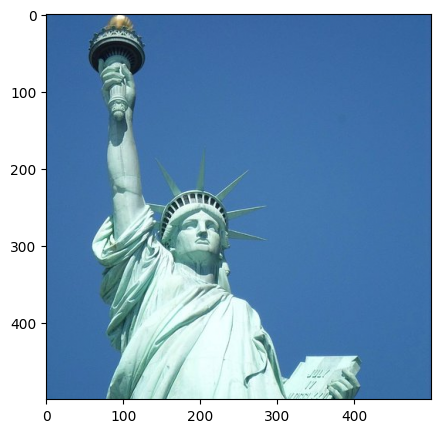

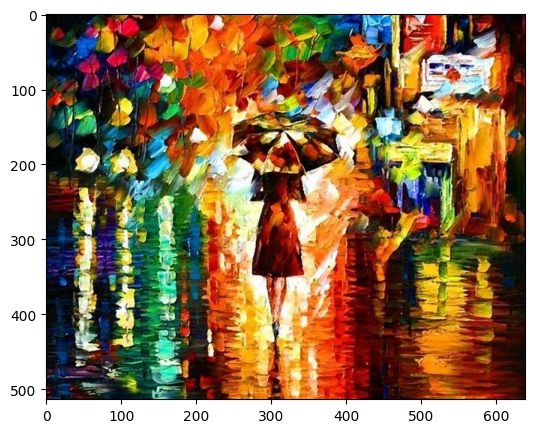

In [12]:
# Load Images
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)

# Display Images
show(content_img)
show(style_img)

---
## 5. Model Setup
---

### 5.1 Load VGGNet-19 Model
*Purpose: Initialize a VGG19 model architecture without any pre-trained weights. Then, load the pre-trained weights of the downloaded model into the VGG19 model.*

Line 2: Call `models.vgg19` from `torchvision.models` to create an instance of the VGG19 model. The `weights=None` argument indicates that no pre-trained weights are loaded, meaning the model is initialized with random weights.

Line 5: Use `torch.load` to load the weights from the file specified by `VGG19_PATH`. The `load_state_dict()` method loads these weights into the model. The `strict=False` argument allows for partial loading of the weights, meaning it will not raise an error if some keys in the state dictionary do not match.

In [13]:
# Load VGG19 Skeleton
vgg = models.vgg19(weights=None)

# Load pretrained weights
vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias'], unexpected_keys=['classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias'])

### 5.2 Modify Pooling Layer
*Purpose: Replace the pooling layers in the VGG19 model with either average pooling or max pooling layers.*

Line 2: `pool_(model, pool='avg')` takes two arguments. `model` is the neural network model whose pooling layers will be modified. `pool` is a string that determines the type of pooling layer to replace existing ones with. The default is `'avg'` (average pooling).

Line 3: Check if the pool argument is set to `'avg'`. If true, the function will replace `MaxPool2d` layers with `AvgPool2d` layers.

Line 4: Initialize a counter `ct` to keep track of the current layer index.

Line 5: Iterate through the child layers of the `model` using `model.children()`. 

Line 6-7: For each layer, check if the layer is an instance of `nn.MaxPool2d`. If true, replaces it with an `nn.AvgPool2d` layer with the same parameters (`kernel_size=2`, `stride=2`, `padding=0`, `ceil_mode=False`).

Line 8: Increment the counter `ct` to move to the next layer.

Line 9: Check if the `pool` argument is set to `'max'`. If true, the function will replace `AvgPool2d` layers with `MaxPool2d` layers.

Line 10: Initialize the counter `ct` again.

Line 11: Iterate through the child layers of the `model` using `model.children()`.

Line 12-13: For each layer, check if the layer is an instance of `nn.AvgPool2d`. If true, replaces it with an `nn.MaxPool2d` layer with the specified parameters (`kernel_size=2`, `stride=2`, `padding=0`, `dilation=1`, `ceil_mode=False`).

Line 14: Increment the counter `ct` to move to the next layer.

Line 16: Return the modified model with updated pooling layers.

Line 19: This line is commented out, but when uncommented, it applies the `pool_` function to the `vgg.features` part of the VGG model. The `POOL` variable determines whether to switch the pooling layers to average pooling (`'avg'`) or max pooling (`'max'`).

In [14]:
# Function to modify pooling layer
def modify_pooling_layer(model, pool_type='avg'):
    for idx, layer in enumerate(model.children()):
        if isinstance(layer, nn.MaxPool2d) and pool_type == 'avg':
            model[idx] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

        elif isinstance(layer, nn.AvgPool2d) and pool_type == 'max':
            model[idx] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    return model

# Uncomment and apply the pooling modification
# vgg.features = modify_pooling_layer(vgg.features, POOL)

In [15]:
# Print the summary
summary(vgg, input_size=(3, 224, 224), batch_size= 10, device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 224, 224]           1,792
              ReLU-2         [10, 64, 224, 224]               0
            Conv2d-3         [10, 64, 224, 224]          36,928
              ReLU-4         [10, 64, 224, 224]               0
         MaxPool2d-5         [10, 64, 112, 112]               0
            Conv2d-6        [10, 128, 112, 112]          73,856
              ReLU-7        [10, 128, 112, 112]               0
            Conv2d-8        [10, 128, 112, 112]         147,584
              ReLU-9        [10, 128, 112, 112]               0
        MaxPool2d-10          [10, 128, 56, 56]               0
           Conv2d-11          [10, 256, 56, 56]         295,168
             ReLU-12          [10, 256, 56, 56]               0
           Conv2d-13          [10, 256, 56, 56]         590,080
             ReLU-14          [10, 256,

### 5.3 Extract Features Network
*Purpose: Extract the feature extraction part of the VGG19 model, discarding the classifier part.*

<center>

<img src="images/vgg19_architecture.png" alt="VGG19 Architecture" width="250" />

**Figure 5.1:** Architecture of `vgg` (VGGNet-19)

</center>

Line 2: `vgg.features` refers to the feature extraction part of the VGG19 model. In VGG architectures, this typically includes all the convolutional and pooling layers, but excludes the fully connected layers at the end. Use `copy.deepcopy` to create a deep copy of `vgg.features`, ensuring modifications do not affect the original model. 

Line 3: Move the model to the specified device (GPU if CUDA is available, else CPU) using `model.to(device)` for efficient computation.

In [16]:
# Extract only the 'features' network, 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### 5.4 Disable Gradient Tracking
*Disable gradient tracking for the model's parameters during inference.*

Line 2-3: Iterate over each parameter in the model. For each parameter, set `param.requires_grad` to `False`, indicating that gradients should not be computed for these parameters.

In [17]:
# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

---
## 6. Loss Functions
---

All loss functions are basically Mean of the Squared Errors (MSE).

`g`: generated features

`c`: content features

`s`: style features

1. What is Total Variation (TV) Loss ?

The total variation (TV) loss encourages spatial smoothness in the generated image. It was not used by Gatys et al. in their CVPR paper but it can sometimes improve the results. For more details and explanation, see Mahendran and Vedaldi "Understanding Deep Image Representations by Inverting Them" CVPR 2015.

[@jcjohnson](https://github.com/jcjohnson/neural-style/issues/302 (GitHub))

2. How to implement TV Loss?

[Total variation denoising](https://en.wikipedia.org/wiki/Total_variation_denoising (Wikipedia))

### 6.1 Mean Squared Error (MSE) Loss
*Purpose: Define the mean squared error (MSE) loss function, which is commonly used to measure the difference between two tensors.*

Line 1: `torch.nn.MSELoss` creates a MSE loss function, which will be used in content and style loss calculations.. The loss is calculated as the mean of the squared differences between corresponding elements of the input and target tensors.

In [18]:
mse_loss = torch.nn.MSELoss()

### 6.2 Gram Matrix Calculation Function
*Purpose: Compute the Gram matrix of a given tensor.*

Line 3-4 (Reshaping): Extract the batch size, number of channels, height, and width of the input tensor. Reshape the tensor to have dimensions `(C, H * W)`, flattening the spatial dimensions.

Line 5 (Matrix multiplication): Compute the Gram matrix as the matrix product of the reshaped tensor with its transpose (`x.t()`). The resulting Gram matrix represents the correlations between different features and is crucial for capturing style information.

In [19]:
# Gram matrix calculation function
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H * W)
    return torch.mm(x, x.t())

### 6.3 Content Loss Function
*Purpose: Compute the content loss between the generated image features and the content image features.*

Line 3: Use the previously defined `mse_loss` to calculate the MSE between the generated features (`g`) and the content features (`c`).

Line 4: Return the content loss value.

In [20]:
# Content loss function
def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss

### 6.4 Style Loss Function
*Purpose: Compute the style loss between the generated image features and the style image features.*

Line 3: Extract the shape of the generated features (`g`), specifically the number of channels (`c1` and `c2`). 

Line 4: Use the `mse_loss` to calculate the MSE between the generated features (`g`) and the style features (`s`). 

Line 5: Divide the loss by the square of the number of channels (`c1 ** 2`) to normalize the loss. Return the normalized style loss value.

In [21]:
# Style loss function
def style_loss(g, s):
    c1, c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1 ** 2) # Divide by square of channels

### 6.5 Total Variation (TV) Loss Function
*Purpose: Compute the total variation (TV) loss, which encourages spatial smoothness in the generated image by penalizing large differences between adjacent pixels in both horizontal and vertical directions. An optional addition that can help improve visual quality by reducing noise.*

Line 3 (Horizonal differences): Compute the difference between adjacent pixels in the horizontal direction: `c[:,:,1:,:] - c[:,:,:-1,:]`.

Line 4 (Vertical differences): Compute the difference between adjacent pixels in the vertical direction: `c[:,:,:,1:] - c[:,:,:,:-1]`.

Line 5 (Sum of absolute differences): Calculate the sum of the absolute values of these differences to measure the total variation.

Line 6: Return the total variation loss value.

In [22]:
# Total variation loss function
def tv_loss(c):
    x = c[:, :, 1:, :] - c[:, :, :-1, :]
    y = c[:, :, :, 1:] - c[:, :, :, :-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

---
## 7. Feature Extraction Function
---
*Purpose: Extract features from specific layers of a VGG model for use in style transfer tasks, including both content and style layers.*

<center>

**Table 7.1:** Architecture of `model` (Excluding 'Classifier' Network)
| Conv Block | Index | Name      | Type       | Description             |
|:----------:|:-----:|-----------|------------|:-----------------------:|
| 1st        | 0     | `conv1_1` | **Convo2d**| k=64, f=3, p=1          |
|            | 1     | `relu1_1` | *ReLU*     |                         |
|            | 2     | `conv1_2` | **Convo2d**| k=64, f=3, p=1          |
|            | 3     | `relu1_2` | *ReLU*     |                         |
|            | 4     | `pool1 `  | MaxPool2d  | f=2, s=2                |
| 2nd        | 5     | `conv2_1` | **Convo2d**| k=128, f=3, p=1         |
|            | 6     | `relu2_1` | *ReLU*     |                         |
|            | 7     | `conv2_2` | **Convo2d**| k=128, f=3, p=1         |
|            | 8     | `relu2_2` | *ReLU*     |                         |
|            | 9     | `pool2`   | MaxPool2d  | f=2, s=2                |
| 3rd        | 10    | `conv3_1` | **Convo2d**| k=256, f=3, p=1         |
|            | 11    | `relu3_1` | *ReLU*     |                         |
|            | 12    | `conv3_2` | **Convo2d**| k=256, f=3, p=1         |
|            | 13    | `relu3_2` | *ReLU*     |                         |
|            | 14    | `conv3_3` | **Convo2d**| k=256, f=3, p=1         |
|            | 15    | `relu3_3` | *ReLU*     |                         |
|            | 16    | `conv3_4` | **Convo2d**| k=256, f=3, p=1         |
|            | 17    | `relu3_4` | *ReLU*     |                         |
|            | 18    | `pool3`   | MaxPool2d  | f=2, s=2                |
| 4th        | 19    | `conv4_1` | **Convo2d**| k=512, f=3, p=1         |
|            | 20    | `relu4_1` | *ReLU*     |                         |
|            | 21    | `conv4_2` | **Convo2d**| k=512, f=3, p=1         |
|            | 22    | `relu4_2` | *ReLU*     |                         |
|            | 23    | `conv4_3` | **Convo2d**| k=512, f=3, p=1         |
|            | 24    | `relu4_3` | *ReLU*     |                         |
|            | 25    | `conv4_4` | **Convo2d**| k=512, f=3, p=1         |
|            | 26    | `relu4_4` | *ReLU*     |                         |
|            | 27    | `pool4`   | MaxPool2d  | f=2, s=2                |
| 5th        | 28    | `conv5_1` | **Convo2d**| k=512, f=3, p=1         |
|            | 29    | `relu5_1` | *ReLU*     |                         |
|            | 30    | `conv5_2` | **Convo2d**| k=512, f=3, p=1         |
|            | 31    | `relu5_2` | *ReLU*     |                         |
|            | 32    | `conv5_3` | **Convo2d**| k=512, f=3, p=1         |
|            | 33    | `relu5_3` | *ReLU*     |                         |
|            | 34    | `conv5_4` | **Convo2d**| k=512, f=3, p=1         |
|            | 35    | `relu5_4` | *ReLU*     |                         |
|            | 36    | `pool5`   | MaxPool2d  | f=2, s=2                |

Note: `k`: number of filters, `f`: filter or kernel size, `s`: stride, `p`: padding

</center>

Line 4-11: This dictionary maps the specific layer indices (as strings) of the VGG layers to their corresponding human-readable layer names. Layer `relu1_2` through `relu3_2` are style layers, while `relu4_2`, `relu4_3` and `relu5_3`are content layers. 

Line 14: `features` is an empty dictionary initialized to store the extracted features from the specified layers.

Line 15: The input `tensor` is assigned to the variable `x`, which will be processed through the layers of the model.

Line 16: Iterate over the layers in the model's `features` module (`_modules` is a dictionary containing layer names as keys and layer objects as values). `name` is the string identifier of the layer (e.g., '3', '8', etc.). `layer` is the corresponding PyTorch module (e.g., `Conv2d`, `ReLU`, etc.).

Line 17: Pass the input tensor `x` through the current layer to compute the output. This `x` becomes the input to the next layer in the sequence.

Line 18: Check if the current layer's index (`name`) is one of the target layers specified in the `layers` dictionary. If it is, the function extracts the features from that layer.

Line 19: Identify the current layer as a "style layer" based on its `name` (e.g., '3', '8', '13').

Line 20: Extract the batch size (`b`), number of channels (`c`), height (`h`), and width (`w`) from the output tensor's shape.

Line 21: `gram(x)` compute the Gram matrix of the tensor `x`, capturing style information by modelling correlations between feature maps. `gram(x) / (h * w)` normalizes the Gram matrix by dividing by the total number of spatial elements (`h * w`) to ensure scale invariance. `features[layers[name]]` stores the normalized Gram matrix under the corresponding layer's alias from the `layers` dictionary.

Line 22-23: For content layers (not style layers), directly store the unmodified output (`x`) as the feature map. These unaltered feature maps are used to compute the content loss.

Line 26-27: The forward pass is terminated after processing the layer with index `33` (`relu5_3`) to avoid unnecessary computations.

Line 31: Return the `features` dictionary containing the extracted feature maps or Gram matrices for the specified layers.

In [23]:
# VGG forward pass function
def get_features(model, tensor):
    # Layer mapping 
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '13': 'relu3_2',
        '22': 'relu4_2',  # Content layers
        '23': 'relu4_3',
        '33': 'relu5_3'
    }

    # Extract features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if name in ['3', '8', '13']:  # Style layers
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h * w)
            else:  # Content layers
                features[layers[name]] = x

            # Terminate forward pass when reaching the last needed layer
            if name == '33':
                break
    return features

---
## 8. Image Initialization Function
---

### 8.1 Initial Image Tensor Function
*Purpose: Generate an initial image tensor that will be used as the starting point for the style transfer process.*

Line 3: Extract the batch size, number of channels, height, and width from the shape of the `content_tensor`.

Line 4-5 (Start with random noise): If `init_image` is set to `'random'`, create a random tensor with the same shape as the content image (excluding batch dimension). `torch.randn(C, H, W)` generates a tensor of random values from a normal distribution. Scale the random values by multiplying them by `0.001` to ensure the initial random noise is small. Add a batch dimension by using `unsqueeze(0)`, resulting in a tensor of shape `(1, C, H, W)`.

Line 6-7 (Start with content image): If `init_image` is not set to `'random'`, clone and detach the `content_tensor`, creating an initial image that is a copy of the content image. The `clone().detach()` ensures that the initial tensor does not share the same computational graph as the content tensor, preventing unwanted gradients and dependencies during optimization. 

In [24]:
# Function to generate initial image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if init_image == 'random':
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    return tensor

### 8.2 Convert Images to Tensor
*Purpose: Convert the content and style images to PyTorch tensors*

Line 2 (Content image to tensor): Call the `image_to_tensor` function with `content_img` as the argument. Convert the content image to a PyTorch tensor, normalize it, and add a batch dimension. Move the tensor to the specified device (GPU if CUDA is available, else CPU) using `.to(device)`.

Line 3 (Style image to tensor): Similarly, call the `image_to_tensor` function with `style_img` as the argument. Convert the style image to a PyTorch tensor, normalize it, and add a batch dimension. Move the tensor to the specified device using `.to(device)`.

In [25]:
# Convert images to tensor
content_tensor = image_to_tensor(content_img).to(device)
style_tensor = image_to_tensor(style_img).to(device)

### 8.3 Generate Initial Image Tensor
*Purpose: Prepare the initial image tensor, move it to appropriate device, and set it up for gradient-based optimization.*

Line 2: Call the initial function with the `content_tensor` and `INIT_IMAGE` as arguments. The `initial` function generates the initial image tensor based on the specified initialization method (`random` or `content`). 

Line 3: Move the initial image tensor to the specified device using `.to(device)`. Set `requires_grad_(True)` on the tensor, indicating that gradients should be calculated with respect to this tensor during backpropagation. 

In [26]:
# Generate initial image
g = initial(content_tensor, init_image=INIT_IMAGE)
g = g.to(device).requires_grad_(True)

---
## 9. Original Method: Stylize Process
---

### 9.1 Stylize Function
*Purpose: The `stylize` function performs the neural style transfer process by iteratively updating the generated image to minimize the style and content loss functions.*

Line 1: The `stylize` function is defined with one argument, `iteration`, which defaults to the global variable `NUM_ITER`.

Line 3-4: `content_layers` and `style_layers` specify which layers' features to extract for computing the content and style losses, respectively.

Line 7-8: `content_weights` and `style_weights` define the weights for each layer's contribution to the total loss.

Line 11-12: Call `get_features` on the model with `content_tensor` and `style_tensor` to extract features from the content image and style image respectively using the specified layers.

Line 14: Iterates over the number of iterations specified (default is `NUM_ITER`).

Line 15: Define the `closure` function to encapsulate the gradient computation and loss calculation for optimisation.

Line 17: Call `optimizer.zero_grad()` to clear any existing gradients from previous iterations. This is necessary to ensure that gradients from different iterations do not accumulate.

Line 20: Perform a forward pass through the model with the current generated image tensor `g`. Extract features from the generated image (`g`) using the specified layers.

Line 25-26: Iterate over content layers and compute the weighted content loss using the `content_loss` function.

Line 27-28: Iterate over style layers and compute the weighted style loss using the `style_loss` function.

Line 30-31: Multiply the content loss and style loss by their respective global weights (`CONTENT_WEIGHT` and `STYLE_WEIGHT`).

Line 22: Compute the TV loss to encourage spatial smoothness in the generated image. `t_loss = TV_WEIGHT * tv_loss(g.clone().detach())` computes the TV loss and applies its weight.

Line 33: Compute the total loss as the sum of the content loss, style loss, and TV loss.

Line 35: Perform backpropagation by calling `total_loss.backward(retain_graph=True)` to compute the gradients of the total loss with respect to the generated image tensor `g`. The `retain_graph=True` argument allows for retaining the computation graph, which is necessary for certain optimization algorithms like `L-BFGS`.

Line 39-40: Log losses (`style loss`, `content loss`, `TV loss`, and `total loss`) at regular intervals defined by `SHOW_ITER`.

Line 41-42: If `PRESERVE_COLOR` is `True`, create a clone of the `content_tensor` and detach it from the computational graph, then convert the cloned and detached content tensor to an image format using the `tensor_to_image` function. Create a clone of the generated tensor `g` and detach it from the computational graph, then convert the cloned and detached generated tensor to an image format using the `tensor_to_image` function. Call the `transfer_color` function, which transfers the colour scheme from the content image to the generated image. This function combines the luminance of the generated image (which contains the stylized content) with the chrominance (color information) of the content image.
(If `PRESERVE_COLOR` is `True`, the function transfers the colors from the original content image to the generated stylized image to maintain the content image's color scheme.)

Line 43-44: If `PRESERVE_COLOR` is `False`, create a clone of the generated tensor `g` and detach it from the computational graph, then convert the cloned and detached generated tensor to an image format using the `tensor_to_image` function, retaining the colours produced by the style transfer.
(If `PRESERVE_COLOR` is `False`, the generated image is used as is, with the colours determined by the style transfer process.)

Line 45-46: Display and save the generated image.

Line 49: Return the total loss for the current iteration. This is used by the optimizer to update the generated image tensor `g`.

Line 52: Call `optimizer.step(closure)` to update the generated image tensor `g` based on the computed gradients. The closure function is executed to perform the forward pass, loss computation, and backpropagation for each optimization step.

Line 54: Return the final generated image tensor `g` after all iterations are completed.

In [27]:
def stylize(iteration=NUM_ITER, content_num=None, style_num=None):   
    # Extract numbers from paths at the start of the function
    if content_num is None and CONTENT_PATH:
        content_num = CONTENT_PATH.split('Content_')[-1].split('.')[0]
    if style_num is None and STYLE_PATH:
        style_num = STYLE_PATH.split('Style_')[-1].split('.')[0]

    # Define the layers to use for content and style features
    content_layers = ['relu4_2', 'relu4_3', 'relu5_3']
    style_layers = ['relu1_2', 'relu2_2', 'relu3_2']
    
    # Assign weights to each layer
    content_weights = {'relu4_2': 1.0, 'relu4_3': 0.7, 'relu5_3': 0.3}
    style_weights = {'relu1_2': 0.5, 'relu2_2': 0.3, 'relu3_2': 0.2}

    # Get feature representations
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)

    for i in range(1, iteration + 1):
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, g)

            # Compute Losses
            c_loss = 0
            s_loss = 0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])

            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)

            # Print loss, show and save image
            if i % SHOW_ITER == 0:
                # Log the losses
                losses = {
                'style': s_loss.item(),
                'content': c_loss.item(),
                'tv': t_loss.item(),
                'total': total_loss.item()
                }
                log_losses(i, losses, 'Original_NST', content_num, style_num)
                
                print(f"Iteration {i}")
                print(f"Style Loss: {s_loss.item()} | Content Loss: {c_loss.item()} | TV Loss: {t_loss} | Total Loss : {total_loss.item()}")
                if PRESERVE_COLOR:
                    g_ = transfer_color(tensor_to_image(content_tensor.clone().detach()), 
                                    tensor_to_image(g.clone().detach()))
                else:
                    g_ = tensor_to_image(g.clone().detach())
                show(g_)
                save_image(g_, i, directory='outputs/Original_NST', prefix='out_ori',
                        content_num=content_num, style_num=style_num)
                plt.show()

            return total_loss

        # Weight/Pixel update
        optimizer.step(closure)

    return g

### 9.2 Define Optimizer
*Purpose: Set up the optimizer to minimize the total loss by updating the generated image tensor `g`.*

Line 1: Check the value of the `OPTIMIZER` variable to determine which optimizer to use.

Line 2: If `OPTIMIZER` is set to `'lbfgs'`, use the `LBFGS` optimizer from PyTorch's `torch.optim` module. `LBFGS` is a second-order optimizer well-suited for tasks like neural style transfer where convergence to a high-quality local minimum is important. The optimizer is instantiated with `[g]` to indicate that the tensor `g` is the parameter to be optimized.

Line 3-4: If `OPTIMIZER` is not `'lbfgs'`, uses the `Adam` optimizer from PyTorch's `torch.optim` module. The optimizer is instantiated with `[g]` and a learning rate specified by `ADAM_LR`.

In [28]:
if (OPTIMIZER == 'lbfgs'):
    optimizer = optim.LBFGS([g])
else:
    optimizer = optim.Adam([g], lr=ADAM_LR)

### 9.3 Execute Stylization

C:\Users\ASUS\AppData\Local\Temp\ipykernel_40452\1876981741.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Iteration 20
Style Loss: 756539.9375 | Content Loss: 655775.25 | TV Loss: 47676.46875 | Total Loss : 1459991.75


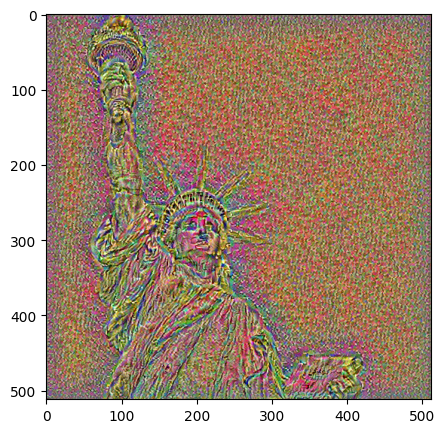

Iteration 40
Style Loss: 272014.40625 | Content Loss: 394393.375 | TV Loss: 44323.72265625 | Total Loss : 710731.5


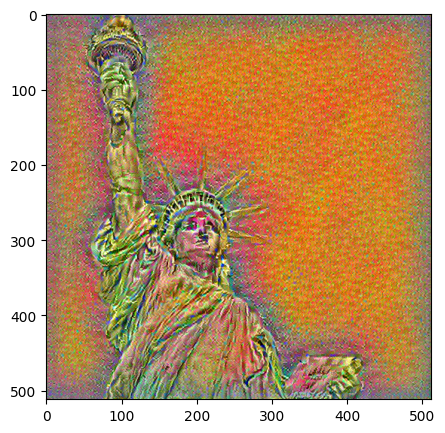

Iteration 60
Style Loss: 208522.65625 | Content Loss: 294430.8125 | TV Loss: 46018.07421875 | Total Loss : 548971.5625


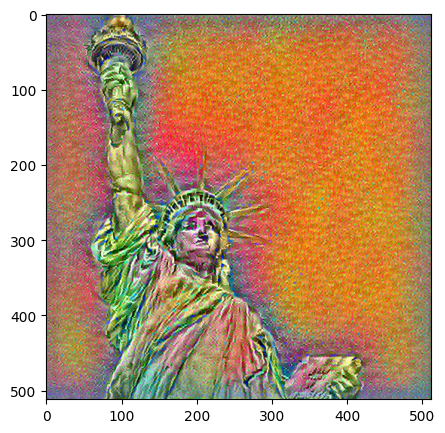

Iteration 80
Style Loss: 175559.359375 | Content Loss: 252938.140625 | TV Loss: 46997.69140625 | Total Loss : 475495.1875


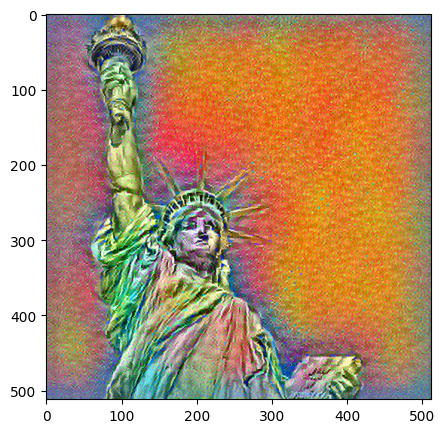

Iteration 100
Style Loss: 166728.609375 | Content Loss: 226241.109375 | TV Loss: 47739.00390625 | Total Loss : 440708.71875


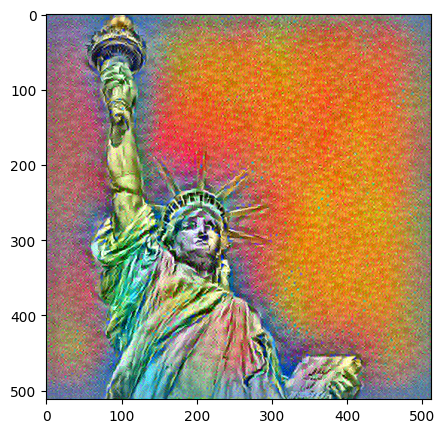

In [29]:
# Stylize
out = stylize(iteration=NUM_ITER)

---
## 10. High & Low Pass Filters
---

### 10.1 xDoG Filter Function

Line 2: Define the `xdog_filter` function to apply the eXtended Difference of Gaussians (xDoG) filter on an image.
- `img`: Input image (in BGR format).
- `sigma`: Standard deviation for the first Gaussian blur.
- `k`: Scaling factor for the second Gaussian blur.
- `epsilon`: Threshold for edge detection.
- `phi`: Controls the sharpness of the edge enhancement.
- `low_pass`: If `True`, returns the low-pass filtered image (`g1`) instead of applying xDoG.

Line 4: Convert the input image from BGR to grayscale because the xDoG filter operates on single-channel intensity values.

Line 7: `g1` is the first Gaussian blur of the grayscale image with standard deviation `sigma`. `g2` is the second Gaussian blur with a scaled standard deviation (`sigma * k`). Both use `(0, 0)` for the kernel size, which is automatically calculated based on `sigma`.

Line 11: Compute the Difference of Gaussians (DoG) by subtracting the second blurred image (`g2`) from the first blurred image (`g1`). Highlight edges and transitions in the image.

Line 12-13: If `low_pass` is `True`, returns the first Gaussian-blurred image (`g1`).

Line 14-15: Divide the DoG image (`dog`) by 255 to normalize its values to the range [0, 1]. Clip any values outside this range to ensure valid intensity values.

Line 16: Apply a hyperbolic tangent (tanh) function to the normalized DoG values, controlled by:
- `phi`: Determine the sharpness of the edge enhancement (higher values result in sharper transitions).
- `epsilon`: Act as a threshold for edge detection, determining the regions considered as edges.
Add 1 to shift the resulting values to the range [0, 2].

Line 17: Scale the processed image back to the 8-bit range [0, 255]. Convert the floating-point values to `uint8`, suitable for image display and storage.

In [30]:
# Function to apply xDoG filter
def xdog_filter(img, sigma=0.5, k=1.6, epsilon=-0.1, phi=10, low_pass=False):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Gaussian blur (original and scaled kernel)
    g1 = cv2.GaussianBlur(gray, (0, 0), sigma)
    g2 = cv2.GaussianBlur(gray, (0, 0), sigma * k)

    # xDoG formula
    dog = g1 - g2
    if low_pass:
        return g1  # Low-pass filtering
    dog = dog / 255.0  # Normalize between 0 and 1
    dog = np.clip(dog, 0, 1)
    dog = 1 + np.tanh(phi * (dog - epsilon))  # Non-linear response
    return (dog * 255).astype(np.uint8)

### 10.2 Display and Save Low and High Frequency Filtered Images 

Low-Frequency Content Image


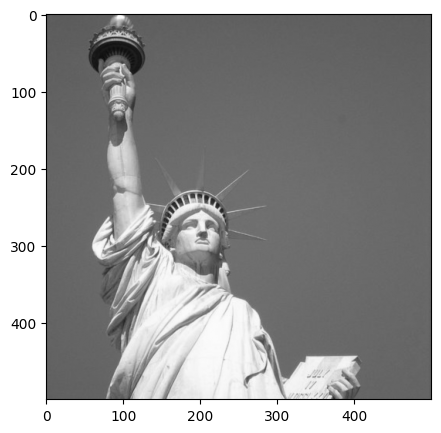

Low-Frequency Style Image


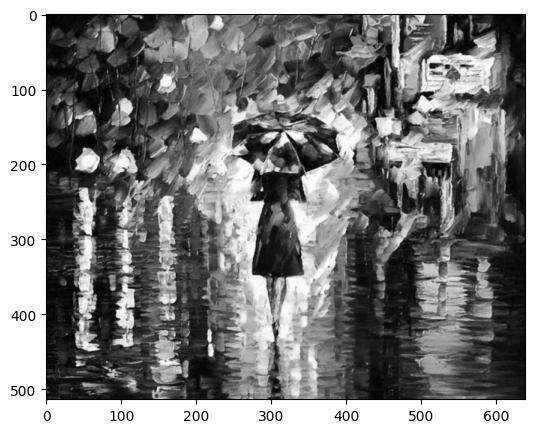

High-Frequency Content Image


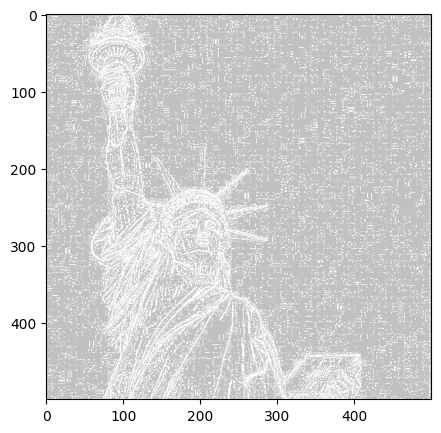

High-Frequency Style Image


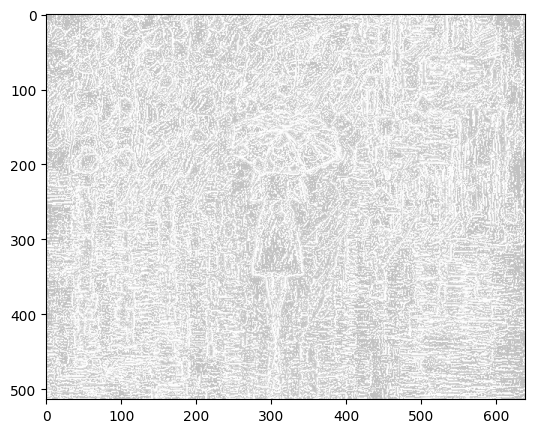


Images have been saved to: outputs/L-H_Frequency_Images


In [31]:
def display_filtered_images():
    # Create output directory if it doesn't exist
    output_dir = 'outputs/L-H_Frequency_Images'
    os.makedirs(output_dir, exist_ok=True)
    
    # Store the original save path to restore it later
    original_path = os.getcwd()
    
    # Generate filtered images
    low_content = xdog_filter(content_img, sigma=0.5, k=1.6, epsilon=-0.1, phi=10, low_pass=True)
    low_style = xdog_filter(style_img, sigma=0.5, k=1.6, epsilon=-0.1, phi=10, low_pass=True)
    high_content = xdog_filter(content_img, sigma=0.5, k=1.6, epsilon=-0.1, phi=10, low_pass=False)
    high_style = xdog_filter(style_img, sigma=0.5, k=1.6, epsilon=-0.1, phi=10, low_pass=False)

    # Save the images with the correct naming convention
    save_image(low_content, 'low_content', directory=output_dir)
    save_image(low_style, 'low_style', directory=output_dir)
    save_image(high_content, 'high_content', directory=output_dir)
    save_image(high_style, 'high_style', directory=output_dir)
    
    # Display the images
    print("Low-Frequency Content Image")
    show(low_content)
    print("Low-Frequency Style Image")
    show(low_style)
    print("High-Frequency Content Image")
    show(high_content)
    print("High-Frequency Style Image")
    show(high_style)
    
    print("\nImages have been saved to:", output_dir)

# Display the filtered images
display_filtered_images()

## 11. Proposed Method: Dual-Channel

### 11.1 Frequency Filter Function

*Purpose: Apply a frequency-based filter to an input image tensor, normalising and resizing the filter to match the input tensor dimensions.*

Line 2: Convert `freq_img` (a NumPy array) into a PyTorch tensor of type `float32` and moves it to the same device (`device`) as the model or tensors.

Line 3-6: If `freq_tensor` is a grayscale image (2D), two singleton dimensions are added, making its shape `[1, 1, height, width]`. If `freq_tensor` is a colour image (3D), one singleton dimension is added, making its shape `[1, channels, height, width]`.

Line 8: Normalize `freq_tensor` values to the range [0, 1] by subtracting the minimum value (`freq_tensor.min()`), then divided by the range (`freq_tensor.max() - freq_tensor.min()`) to scale values between 0 and 1. Add `1e-8` to prevent division by zero.

Line 9-14: Resize `freq_tensor` to match the spatial dimensions (`height` and `width`) of `tensor` using bilinear interpolation.`size=(tensor.shape[2], tensor.shape[3])` ensures that the frequency filter matches the dimensions of the input tensor. `align_corners=False` ensures consistent resizing behaviour when downscaling or upscaling.

Line 16: Apply the frequency filter to the input tensor using element-wise multiplication. This operation scales the pixel intensities of `tensor` based on the filter's values.

Line 17: Return the filtered tensor, which now contains the original image tensor's content modulated by the frequency filter.

In [32]:
def apply_frequency_filter_normalized(tensor, freq_img):
    freq_tensor = torch.from_numpy(freq_img).float().to(device)
    if len(freq_tensor.shape) == 2:
        freq_tensor = freq_tensor.unsqueeze(0).unsqueeze(0)
    elif len(freq_tensor.shape) == 3:
        freq_tensor = freq_tensor.unsqueeze(0)
    
    freq_tensor = (freq_tensor - freq_tensor.min()) / (freq_tensor.max() - freq_tensor.min() + 1e-8)
    freq_tensor = torch.nn.functional.interpolate(
        freq_tensor, 
        size=(tensor.shape[2], tensor.shape[3]), 
        mode='bilinear', 
        align_corners=False
    )
    
    filtered = tensor * freq_tensor
    return filtered

### 11.2 Style Loss Function

*Purpose: Compute the style loss between the generated image (`g`) and the style image (`s`). Style loss measures how well the generated image matches the style image in terms of texture, patterns, and style features.*

Line 3-6: Determine if the inputs are feature maps or already Gram matrices. If the inputs are feature maps (dimensions `[batch_size, channels, height, width]`), convert both `g` and `s` to Gram matrices using the `gram` function. Divide the resulting Gram matrix by the total number of elements (`c * h * w`) to normalize it.

Line 8: Compute the Mean Squared Error (MSE) loss between the Gram matrix (or features) of the generated image (`g`) and the style image (`s`). This measures the difference in style representations between the generated and style images.

Line 9: Return the computed style loss for further optimisation during the style transfer process.

In [33]:
def style_loss(g, s):
    # If input is feature maps, convert to gram matrices
    if len(g.shape) > 2:
        b, c, h, w = g.shape
        g = gram(g) / (c * h * w)
        s = gram(s) / (c * h * w)
    
    loss = mse_loss(g, s)
    return loss

### 11.3 Modified Feature Extraction Function

In [34]:
# Modified get_features function for frequency-specific processing
def get_features_freq(model, tensor, freq_type='low'):
    layers = {
        '3': 'relu1_2',
        '8': 'relu2_2',
        '13': 'relu3_2',
        '22': 'relu4_2',
        '23': 'relu4_3',
        '33': 'relu5_3'
    }
    
    features = {}
    x = tensor
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            layer_name = layers[name]
            # Store raw features for all layers
            features[layer_name] = x
                
    return features

### 11.4 Dual-Channel Stylization Function

*Purpose: Implement a dual-channel neural style transfer process, alternately applying low-frequency and high-frequency filters to the generated image during the optimisation process.*

Line 3-14: Assign relative importance to style features from early layers (`relu1_2`, `relu2_2`, `relu3_2`). Early layers focus on textures and patterns. Assign relative importance to content features from deeper layers (`relu4_2`, `relu4_3`, `relu5_3`). Deeper layers focus on spatial and semantic content.

Line 17-20: Separate low-frequency (broad structure) and high-frequency (fine details) components from the content and style images. `low_pass=True` extracts low-frequency structure. `low_pass=False` extracts high-frequency details.

Line 22-25: Apply the low/high-frequency filters to the content and style tensors using the `apply_frequency_filter_normalized` function. This prepares frequency-specific inputs for the style transfer process.

Line 28-31: Extract feature representations from the filtered content and style tensors (low- and high-frequency) using the modified VGG19 model. These features will later be compared to the corresponding features from the generated image during each iteration.

Line 34-41: Define the layers to be used for style and content loss computation for both low and high-frequency components.

Line 43: Run the optimisation process for the specified number of iterations (`NUM_ITER`).

Line 47: Alternate between low-frequency (`freq_type='low'`) and high-frequency (`freq_type='high'`) processing on each iteration.

Line 49-56: Apply the corresponding frequency filter to the generated image (`g`). Assign the current content and style features based on the frequency type.

Line 58: Extract features from the frequency-filtered generated image (`g_freq`) using the VGG model.

Line 60-61: Initialize style and content loss values for the current iteration.

Line 64-66: Iterate through the style layers for the current frequency type and computes the style loss for each layer. Multiply each loss by the corresponding layer weight and add it to the total `style_loss_val`.

Line 69-71: Iterate through the content layers for the current frequency type and computes the content loss for each layer. Multiply each loss by the corresponding layer weight and add it to the total `content_loss_val`.

Line 74-77: Apply global weights (`STYLE_WEIGHT`, `CONTENT_WEIGHT`, `TV_WEIGHT`) to style, content, and total variation losses. Compute the total loss as the sum of these components.

Line 79: Backpropagate the total loss to compute gradients for the generated image (`g`).

Line 81-90: Every `SHOW_ITER` iterations, log the current iteration and loss values. Convert the generated image (`g`) to a displayable format, show or save it.

Line 96: Return the optimised generated image tensor (`g`) after completing all iterations.

In [35]:
def dual_channel_stylize(iteration=NUM_ITER, content_num=None, style_num=None):
    # Extract numbers from paths at the start of the function
    if content_num is None and CONTENT_PATH:
        content_num = CONTENT_PATH.split('Content_')[-1].split('.')[0]
    if style_num is None and STYLE_PATH:
        style_num = STYLE_PATH.split('Style_')[-1].split('.')[0]

    # Weights for style layers (early layers)
    style_weights = {
        'relu1_2': 0.4,  # Increased weight for fine details
        'relu2_2': 0.3,  # Medium-level style features
        'relu3_2': 0.3   # Higher-level style features
    }
    
    # Weights for content layers (deeper layers)
    content_weights = {
        'relu4_2': 0.4,  # Primary content features
        'relu4_3': 0.3,  # Additional semantic content
        'relu5_3': 0.3   # High-level content structure
    }   
    
    # Get and process frequency filtered images
    low_content = xdog_filter(content_img, sigma=0.8, k=1.6, epsilon=-0.1, phi=10, low_pass=True)
    low_style = xdog_filter(style_img, sigma=0.8, k=1.6, epsilon=-0.1, phi=10, low_pass=True)
    high_content = xdog_filter(content_img, sigma=0.4, k=1.6, epsilon=-0.1, phi=10, low_pass=False)
    high_style = xdog_filter(style_img, sigma=0.4, k=1.6, epsilon=-0.1, phi=10, low_pass=False)
    
    content_low = apply_frequency_filter_normalized(content_tensor, low_content)
    style_low = apply_frequency_filter_normalized(style_tensor, low_style)
    content_high = apply_frequency_filter_normalized(content_tensor, high_content)
    style_high = apply_frequency_filter_normalized(style_tensor, high_style)
    
    # Get features
    c_feat_low = get_features_freq(model, content_low)
    s_feat_low = get_features_freq(model, style_low)
    c_feat_high = get_features_freq(model, content_high)
    s_feat_high = get_features_freq(model, style_high)
    
    # Layer assignments
    style_layers = {
        'low': ['relu1_2', 'relu2_2', 'relu3_2'],    # Style features in early layers
        'high': ['relu1_2', 'relu2_2', 'relu3_2']    # Still use style layers for high frequency
    }
    content_layers = {
        'low': ['relu4_2', 'relu4_3', 'relu5_3'],    # Content features in deeper layers
        'high': ['relu4_2', 'relu4_3', 'relu5_3']    # Content features for high frequency
    }
    
    for i in range(1, iteration + 1):
        def closure():
            optimizer.zero_grad()
            
            freq_type = 'low' if i % 2 == 1 else 'high'
            
            if freq_type == 'low':
                g_freq = apply_frequency_filter_normalized(g, low_content)
                current_features = c_feat_low
                current_style_features = s_feat_low
            else:
                g_freq = apply_frequency_filter_normalized(g, high_content)
                current_features = c_feat_high
                current_style_features = s_feat_high
            
            g_feat = get_features_freq(model, g_freq)
            
            style_loss_val = torch.tensor(0., device=device)
            content_loss_val = torch.tensor(0., device=device)
            
            # Style loss computation using early layers
            for layer in style_layers[freq_type]:
                layer_style_loss = style_loss(g_feat[layer], current_style_features[layer])
                style_loss_val += style_weights[layer] * layer_style_loss
            
            # Content loss computation using deeper layers
            for layer in content_layers[freq_type]:
                layer_content_loss = content_loss(g_feat[layer], current_features[layer])
                content_loss_val += content_weights[layer] * layer_content_loss
            
            # Apply global weights
            style_loss_val = STYLE_WEIGHT * style_loss_val
            content_loss_val = CONTENT_WEIGHT * content_loss_val
            tv_loss_val = TV_WEIGHT * tv_loss(g)
            total_loss = style_loss_val + content_loss_val + tv_loss_val
            
            total_loss.backward(retain_graph=True)
            
            if i % SHOW_ITER == 0:
                # Log the losses
                losses = {
                'style': style_loss_val.item(),
                'content': content_loss_val.item(),
                'tv': tv_loss_val.item(),
                'total': total_loss.item()
                }
                log_losses(i, losses, 'Dual_Channel_NST', content_num, style_num)

                print(f"Iteration {i}")
                print(f"Style Loss: {style_loss_val.item():.4f} | Content Loss: {content_loss_val.item():.4f} | TV Loss: {tv_loss_val.item():.4f} | Total Loss: {total_loss.item():.4f}")
                
                if PRESERVE_COLOR:
                    g_ = transfer_color(tensor_to_image(content_tensor.clone().detach()), 
                                    tensor_to_image(g.clone().detach()))
                else:
                    g_ = tensor_to_image(g.clone().detach())
                show(g_)
                save_image(g_, i, directory='outputs/Dual_Channel_NST', prefix='out_dual',
                        content_num=content_num, style_num=style_num)
                
            return total_loss
            
        optimizer.step(closure)
    
    return g

### 11.5 Define Optimizer
*Purpose: Set up the optimizer to minimize the total loss by updating the generated image tensor `g`.*

Line 1: Check the value of the `OPTIMIZER` variable to determine which optimizer to use.

Line 2: If `OPTIMIZER` is set to `'lbfgs'`, use the `LBFGS` optimizer from PyTorch's `torch.optim` module. `LBFGS` is a second-order optimizer well-suited for tasks like neural style transfer where convergence to a high-quality local minimum is important. The optimizer is instantiated with `[g]` to indicate that the tensor `g` is the parameter to be optimized.

Line 3-4: If `OPTIMIZER` is not `'lbfgs'`, uses the `Adam` optimizer from PyTorch's `torch.optim` module. The optimizer is instantiated with `[g]` and a learning rate specified by `ADAM_LR`.

In [36]:
if (OPTIMIZER == 'lbfgs'):
    optimizer = optim.LBFGS([g])
else:
    optimizer = optim.Adam([g], lr=ADAM_LR)

### 11.6 Execute Dual-Channel Stylization

C:\Users\ASUS\AppData\Local\Temp\ipykernel_40452\1876981741.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Iteration 20
Style Loss: 112038.9844 | Content Loss: 57236.8008 | TV Loss: 35831.7383 | Total Loss: 205107.5156


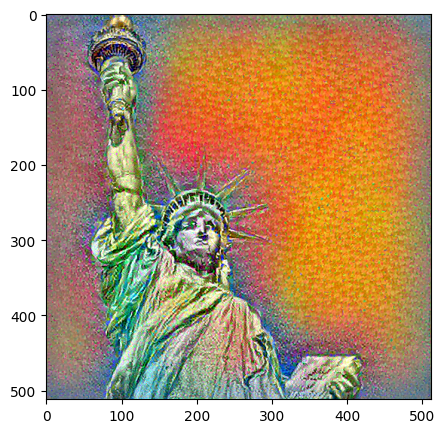

Iteration 40
Style Loss: 106784.2188 | Content Loss: 37997.1953 | TV Loss: 28584.6406 | Total Loss: 173366.0469


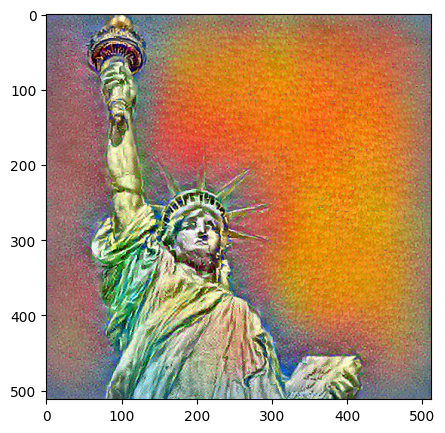

Iteration 60
Style Loss: 96821.9922 | Content Loss: 35313.0977 | TV Loss: 26099.0176 | Total Loss: 158234.1094


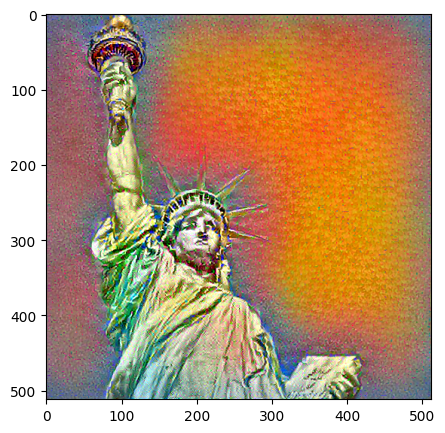

Iteration 80
Style Loss: 88713.1719 | Content Loss: 34944.8945 | TV Loss: 25598.5781 | Total Loss: 149256.6406


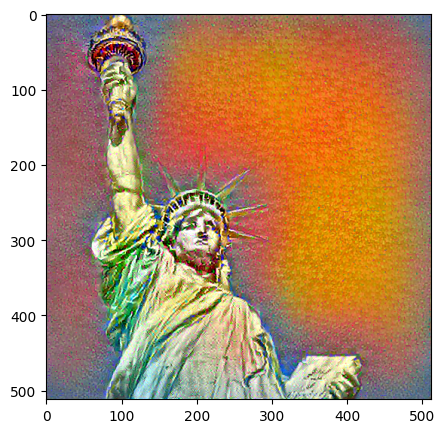

Iteration 100
Style Loss: 82847.2500 | Content Loss: 34432.9766 | TV Loss: 24994.8691 | Total Loss: 142275.0938


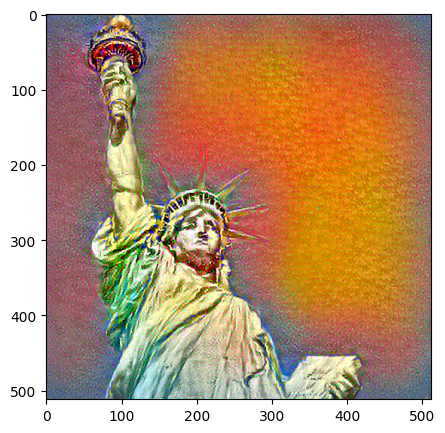

In [37]:
final_image = dual_channel_stylize(iteration=NUM_ITER)